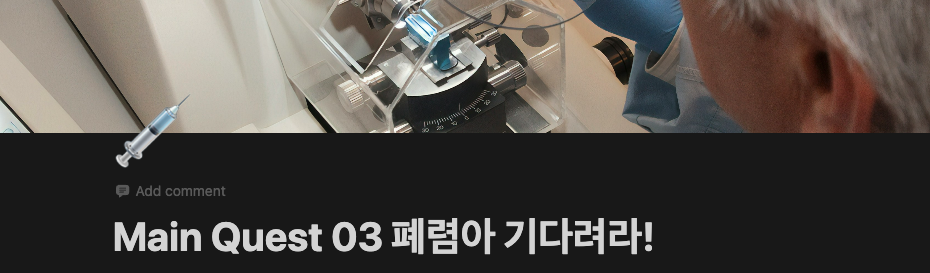

### 개요: 의료영상을 처리하는 CNN 기반 베이스 모델 구현 및 성능개선

### 목차: 폐렴 진단 및 성능개선

- 데이터 준비
- 모델 아키텍처
- CNN 모델 개발
- 훈련
- 결과 분석
- 성능개선

### 목표:
1. 의료영상을 처리하는 CNN 기반 딥러닝 모델 구현

  모델 학습이 안정적으로 수렴하는 것을 시각화하여 확인

2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행

  regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행

3. ResNet 모델을 구현

  ResNet 의 Residual block을 구현하고 학습


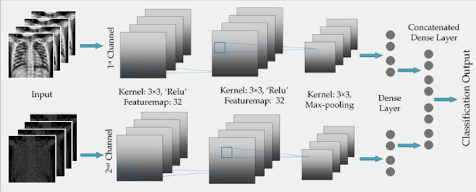

폐렴을 찾아내는 CNN (Convolutional Neural Network) 모델의 일반적인 아키텍처
입력 레이어

	•	흉부 X-ray 이미지 (일반적으로 크기 조정됨, 예: 224x224x3)

특징 추출 부분

	1.	컨볼루션 레이어
	  •	여러 개의 컨볼루션 레이어 스택
	  •	각 레이어 뒤에 활성화 함수 (주로 ReLU)
	2.	풀링 레이어
	  •	주로 Max Pooling 사용
	3.	배치 정규화
	  •	학습 안정화 및 과적합 방지

분류 부분

	1.	Flatten 레이어
	  •	2D 특징 맵을 1D 벡터로 변환
	2.	완전 연결 레이어 (Dense)
	  •	하나 이상의 완전 연결 레이어
	3.	Dropout 레이어
	  •	과적합 방지 (일반적으로 0.5 또는 0.7의 비율 사용)
	4.	출력 레이어
	  •	2개의 뉴런 (정상 vs 폐렴)
	  •	활성화 함수: Sigmoid 또는 Softmax

추가적인 개선 사항

	  •	주의 메커니즘 (Attention mechanism)
	  •	잔차 연결 (Residual connections)
	  •	다중 스케일 특징 융합

VGG16, VGG19, DenseNet121, EfficientNetB0 등의 사전 학습된 모델을 기반으로 할 수 있으며, 전이 학습을 통해 성능을 향상시켜볼 계획

In [ ]:
# 패키지 import
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

# 변수 생성
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks'
TRAIN_PATH = ROOT_PATH + '/chest_xray/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/test/*/*'

BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [10]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

2743
0
16


In [11]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

1148
287


In [12]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/content/drive/MyDrive/Colab Notebooks/chest_xray/train/NORMAL/IM-0544-0001.jpeg


IndexError: list index out of range

In [13]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1080
Pneumonia images count in training set: 68


In [14]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [ ]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

In [ ]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [ ]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [ ]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

In [ ]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

In [ ]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [ ]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

conv_block()의 구성은 Convolution을 두 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결합니다. 그리고 Max Pooling을 합니다.

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

In [ ]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

In [ ]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

In [ ]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

결과 확인:

### Summary:

**평가문항 (상세기준)**

**1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.**

**모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.**

**2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.**

**regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.**

**3. ResNet 모델을 구현 하였다**

**Resnet 의 Residual block을 구현하고 학습의 경우 1에폭만 진행하여도 인정**

### 회고:

퀘스트를 진행하면서 정말 많은 부분을 배울 수 있었다. 직접 해보는 것과 과정을 따라 가는 것은 완전히 다르다는 것을 다시 한번 느꼈다. 데이터의 중요성과 데이터를 가지고 어떻게 모델링하면 좋은 결과가 나오는지 여러가지 방법을 통해서 알아 볼 수 있는 좋은 기회였다.

### Reference:

https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download

https://data.mendeley.com/datasets/rscbjbr9sj/2

https://www.kaggle.com/code/amyjang/tensorflow-pneumonia-classification-on-x-rays

http://taewan.kim/post/cnn/#google_vignette

https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf

https://acdongpgm.tistory.com/202#google_vignette